# 🥑 ChefMate: The Multimodal Zero-Waste Kitchen Agent

**Track:** Agents for Good / Freestyle

## 1. The Problem
Households waste tons of food simply because they look at a fridge full of random ingredients and think, *"I have nothing to eat."* Figuring out how to combine mismatched items is mentally taxing.

## 2. The Solution
**ChefMate** is a multimodal AI agent that removes this friction.
* **See:** It uses **Gemini 1.5 Flash (Vision)** to "look" into your fridge.
* **Search:** It uses **DuckDuckGo Search** to find valid culinary uses for those specific items.
* **Solve:** It synthesizes a coherent, zero-waste recipe card, helping users save money and the planet.

## 3. Technical Architecture
* **Model:** Google Gemini 1.5 Flash (via `google-genai` SDK).
* **Tools:** DuckDuckGo Search (for real-time recipe grounding).
* **Framework:** Pure Python (No fragile dependencies).

🍳 Setting up the kitchen (Installing libraries)...
✅ API Key loaded from Kaggle Secrets.

📸 Preparing sample image...
   -> Downloaded: https://images.pexels.com/photos/1640777/pexels-photo-1640777.jpeg?auto=compress&cs=tinysrgb&w=600


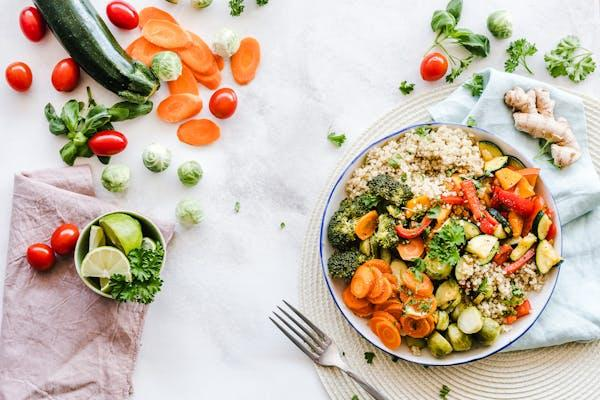


🎛 Move the sliders below to control recipe style, then wait for ChefMate to respond:


/tmp/ipykernel_48/958452586.py:52: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  self.search_tool = DDGS()


interactive(children=(IntSlider(value=7, description='Healthiness', max=10, min=1), IntSlider(value=5, descrip…

<function __main__.run_chef_ui(healthiness_level=7, spice_level=5, max_prep_time=30)>

In [19]:
# ==========================================
# 🏆 CHEFMATE: The Vision-Powered AI Chef (v2)
# - Multi-recipe generator
# - Cuisine classification
# - Sliders: healthiness, spice level, prep time
# ==========================================

# --- 1. INSTALLATION ---
print("🍳 Setting up the kitchen (Installing libraries)...")
!pip install -q google-genai duckduckgo-search pillow ipywidgets

# --- 2. IMPORTS & SETUP ---
import os
import requests
from io import BytesIO

from PIL import Image
from duckduckgo_search import DDGS
from IPython.display import display, Markdown, Image as IPImage

from google import genai
from google.genai import types

from kaggle_secrets import UserSecretsClient
from ipywidgets import interact, IntSlider

# ---------------------------------------------------------
# 🔑 API KEY SETUP — KAGGLE SECRETS
# ---------------------------------------------------------
try:
    secrets = UserSecretsClient()
    API_KEY = secrets.get_secret("GOOGLE_API_KEY")
except Exception as e:
    API_KEY = None
    print("❌ Could not load API key from Kaggle Secrets:", e)

if not API_KEY:
    print("❌ STOP! Add GOOGLE_API_KEY in Kaggle Secrets (Notebook → Add-ons → Secrets).")
else:
    os.environ["GOOGLE_API_KEY"] = API_KEY
    print("✅ API Key loaded from Kaggle Secrets.")


# ---------------------------------------------------------
# 🧠 CHEFMATE AGENT
# ---------------------------------------------------------
class ChefMateAgent:
    def __init__(self, model_name="gemini-2.5-flash", enable_search=True):
        self.client = genai.Client(api_key=os.environ["GOOGLE_API_KEY"])
        self.model_name = model_name
        self.enable_search = enable_search
        self.search_tool = DDGS()

    # -------------------------------
    # Load image for Gemini
    # -------------------------------
    def _load_image_part(self, image_path):
        try:
            with open(image_path, "rb") as f:
                image_bytes = f.read()
            pil_img = Image.open(BytesIO(image_bytes))
            fmt = (pil_img.format or "JPEG").lower()
            if fmt == "jpg":
                fmt = "jpeg"
            mime_type = f"image/{fmt}"
            return types.Part.from_bytes(data=image_bytes, mime_type=mime_type)
        except Exception as e:
            print("⚠️ Error loading image:", e)
            return None

    # -------------------------------
    # Step 1: Extract ingredients
    # -------------------------------
    def identify_ingredients(self, image_path):
        print("\n👀 Identifying ingredients...")

        img = self._load_image_part(image_path)
        if img is None:
            print("   -> Fallback ingredients.")
            return "eggs, spinach, bell peppers, cheese"

        prompt = (
            "You are a strict ingredient detector.\n"
            "Look at this image and list ONLY the main edible ingredients.\n"
            "Return ONLY a comma-separated list in lowercase.\n"
            "If unclear, ask for new image.\n"
        )

        try:
            response = self.client.models.generate_content(
                model=self.model_name, contents=[prompt, img]
            )
            text = (response.text or "").strip()
            if not text:
                raise ValueError("Empty response")
            return text.replace("\n", ", ")
        except Exception as e:
            print("⚠️ Vision error:", e)
            return "eggs, spinach, bell peppers, cheese"

    # -------------------------------
    # Step 2: Optional web recipe search
    # -------------------------------
    def find_recipe_inspiration(self, ingredients):
        print(f"🔎 Searching web for inspiration using: {ingredients} ...")

        if not self.enable_search:
            return None, None, None

        try:
            query = f"creative home recipes using {ingredients}"
            results = list(self.search_tool.text(query, max_results=3))

            if results:
                r = results[0]
                return r.get("title"), r.get("href"), r.get("body")
        except Exception as e:
            print("⚠️ DuckDuckGo error:", e)

        # No hardcoded dish fallback; just no inspiration
        return None, None, None

    # -------------------------------
    # Step 3: Multi-recipe generator
    # -------------------------------
    def generate_multi_recipe_cards(
        self, ingredients, inspiration_title, inspiration_link, inspiration_context,
        healthiness_level, spice_level, max_prep_time
    ):
        print("👨‍🍳 Creating 3 recipes with your preferences...")

        # If no web inspiration, keep those fields simple
        if inspiration_title is None:
            inspiration_title = "None (model must invent recipes)"
            inspiration_link = "N/A"
            inspiration_context = "No external recipe; create fresh, original ideas."

        # Build preference description
        preference_text = (
            f"- Healthiness preference (1–10): {healthiness_level}\n"
            f"- Spice level preference (0–10): {spice_level}\n"
            f"- Maximum acceptable prep time: {max_prep_time} minutes\n"
        )

        prompt = f"""
You are **ChefMate**, an AI chef.

Detected ingredients: {ingredients}

Web inspiration:
- Title: {inspiration_title}
- Link: {inspiration_link}
- Context: {inspiration_context}

User preferences:
{preference_text}

TASK:
Create **3 distinct recipes** using the available ingredients. They can be any style:
bowls, stir-fries, pastas, curries, wraps, soups, etc.

Each recipe MUST:
- Strongly use the provided ingredients.
- Respect the approximate prep time limit.
- Respect healthiness and spice preferences (higher healthiness → lighter, less processed; higher spice → more chili/heat).
- Clearly classify a **probable cuisine** (e.g., Indian, Italian, Thai, Mexican, Mediterranean, Fusion, etc.).

OUTPUT FORMAT:
Return valid GitHub-flavored Markdown in this exact structure:

# 🍽️ ChefMate Recipe Ideas

## Recipe 1: <Title>

### a. Overview
- **Cuisine**: <cuisine guess>
- **Servings**: X
- **Difficulty**: Easy / Medium / Hard
- **Total Time**: X minutes
- **Prep Time**: X minutes
- **Cook Time**: X minutes
- **Spice Level**: mild / medium / hot
- **Healthiness**: short note (e.g., high-protein, low-carb, comfort food)

### b. Description
2–3 appetizing sentences.

### c. Ingredients
Bullet list with quantities. Use the detected ingredients heavily.

### d. Instructions
Numbered clear cooking steps.

### e. Nutrition (Approx) per serving
- Calories
- Protein
- Carbs
- Fat

### f. Smart Shopping List
Grouped by sections:
- Fresh Produce
- Pantry / Dry Goods
- Dairy & Eggs
- Other

### g. 🌿 Zero-Waste Tips
3 bullet points.

---

## Recipe 2: <Title>
(Repeat the same subheadings a–g)

---

## Recipe 3: <Title>
(Repeat the same subheadings a–g)

IMPORTANT:
- The 3 recipes must be clearly different (not minor variations).
- Use the cuisine classification thoughtfully for each recipe.
- Do NOT include anything outside this structure.
"""

        response = self.client.models.generate_content(
            model=self.model_name,
            contents=prompt
        )

        return response.text

    # -------------------------------
    # Main run (with preferences)
    # -------------------------------
    def run(self, image_path, healthiness_level=7, spice_level=5, max_prep_time=30):
        # 1. Vision
        ingredients = self.identify_ingredients(image_path)
        print("✅ Detected ingredients:", ingredients)

        # 2. Web inspiration
        title, link, context = self.find_recipe_inspiration(ingredients)
        if title:
            print(f"✅ Inspiration: {title} ({link})")
        else:
            print("ℹ️ No web recipe used; generating fully original recipes.")

        # 3. Multi-recipe generation
        recipe_md = self.generate_multi_recipe_cards(
            ingredients,
            title,
            link,
            context,
            healthiness_level,
            spice_level,
            max_prep_time
        )

        display(Markdown("---"))
        display(Markdown(recipe_md))
        display(Markdown("---"))


# ---------------------------------------------------------
# 🖼 DEMO IMAGE DOWNLOAD
# ---------------------------------------------------------
print("\n📸 Preparing sample image...")
image_filename = "fridge_sample.jpg"

urls = [
    "https://upload.wikimedia.org/wikipedia/commons/thumb/6/6d/Good_Food_Display_-_NCI_Visuals_Online.jpg/640px-Good_Food_Display_-_NCI_Visuals_Online.jpg",
    "https://images.pexels.com/photos/1640777/pexels-photo-1640777.jpeg?auto=compress&cs=tinysrgb&w=600",
]

download_success = False
for u in urls:
    try:
        r = requests.get(u, timeout=10)
        if r.status_code == 200:
            Image.open(BytesIO(r.content)).convert("RGB").save(image_filename)
            print("   -> Downloaded:", u)
            download_success = True
            break
    except Exception as e:
        print("   -> Failed from:", u, "error:", e)

if not download_success:
    print("   -> Using dummy tomato-colored image as fallback.")
    Image.new("RGB", (300, 300), color="tomato").save(image_filename)

display(IPImage(image_filename, width=300))


# ---------------------------------------------------------
# 🎛️ INTERACTIVE SLIDERS (HEALTH, SPICE, PREP TIME)
# ---------------------------------------------------------
chef = ChefMateAgent(enable_search=True)

def run_chef_ui(healthiness_level=7, spice_level=5, max_prep_time=30):
    """
    This function will be called whenever you move the sliders.
    """
    print(f"\n🎚 Preferences -> Healthiness: {healthiness_level}/10 | "
          f"Spice: {spice_level}/10 | Max prep: {max_prep_time} min")
    chef.run(
        image_path=image_filename,
        healthiness_level=healthiness_level,
        spice_level=spice_level,
        max_prep_time=max_prep_time
    )

print("\n🎛 Move the sliders below to control recipe style, then wait for ChefMate to respond:")

interact(
    run_chef_ui,
    healthiness_level=IntSlider(value=7, min=1, max=10, step=1, description="Healthiness"),
    spice_level=IntSlider(value=5, min=0, max=10, step=1, description="Spice level"),
    max_prep_time=IntSlider(value=30, min=10, max=120, step=5, description="Max prep (min)"),
)
